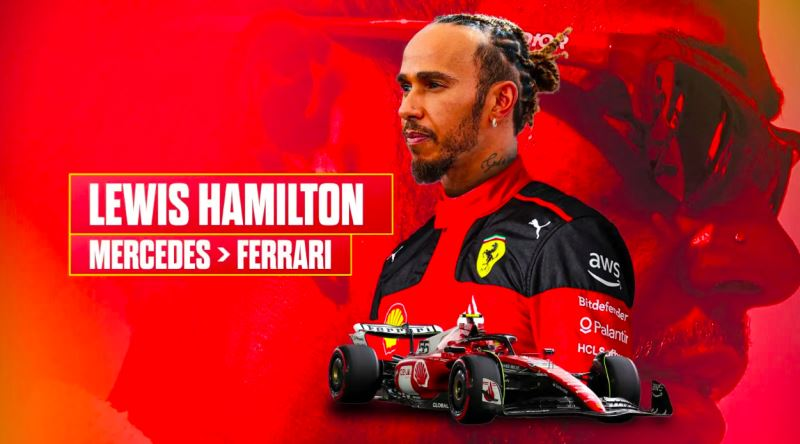

In [1]:
import os
from IPython.display import Image, display

file_path = '/kaggle/input/hamilton-ferrari/Hamilton_Ferrari.jpg'

display(Image(filename=file_path))

# From Mercedes To Ferrari: Hamilton 2025 Predictions

This study aims to predict Lewis Hamilton's performance in the 2025 season on the race calendar tracks with **Mercedes** and **Ferrari** teams.

The objective is to analyze the performance of Mercedes and Ferrari across different tracks while also evaluating Hamilton's individual performance on these tracks. Furthermore, the study aims to **predict Hamilton's performance with both Ferrari and Mercedes to assess the potential impact of his decision to switch to Ferrari in 2025.**

## Datasets and Methods Used

- **Dataset:** Historical Formula 1 results (2005-2024), track characteristics, and team performance data.  
- **Models:** Random Forest, XGBoost, and LightGBM (XGBoost produced the best results, so it was chosen for further analysis.)  
- **Target Variable:** Hamilton_Avg_Position

## Conclusion

Based on the results, we found that Hamilton is likely to **achieve better positions with Ferrari compared to Mercedes on a track-by-track basis.**.



In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Preparation

In [ ]:
results = pd.read_csv("/kaggle/input/formula-1-world-championship-1950-2020/results.csv")
drivers = pd.read_csv("/kaggle/input/formula-1-world-championship-1950-2020/drivers.csv")
constructors = pd.read_csv("/kaggle/input/formula-1-world-championship-1950-2020/constructors.csv")
races = pd.read_csv("/kaggle/input/formula-1-world-championship-1950-2020/races.csv")
qualifying = pd.read_csv ("/kaggle/input/formula-1-world-championship-1950-2020/qualifying.csv")
pit_stops = pd.read_csv("/kaggle/input/formula-1-world-championship-1950-2020/pit_stops.csv")
lap_times = pd.read_csv("/kaggle/input/formula-1-world-championship-1950-2020/lap_times.csv")
constructor_standings = pd.read_csv("/kaggle/input/formula-1-world-championship-1950-2020/constructor_standings.csv")
driver_standings= pd.read_csv("/kaggle/input/formula-1-world-championship-1950-2020/driver_standings.csv")
status = pd.read_csv("/kaggle/input/formula-1-world-championship-1950-2020/status.csv")
circuits = pd.read_csv("/kaggle/input/formula-1-world-championship-1950-2020/circuits.csv")
combined_rrd = pd.read_csv("/kaggle/input/combined-results-drivers-and-races/Combined_Results__Drivers__and_Races_Data.csv", low_memory=False)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)
pd.set_option('display.width', 500)
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# Exctracting Hamilton's, Ferrari's and Mercedes' IDs

hamilton_id = drivers[drivers['forename'] == 'Lewis']['driverId'].values[0]
ferrari_id = constructors[constructors['name'] == 'Ferrari']['constructorId'].values[0]
mercedes_id = constructors[constructors['name'] == 'Mercedes']['constructorId'].values[0]

In [ ]:
# Filtering results acc. Hamilton and Ferrari

filtered_results = results[(results['driverId'] == hamilton_id) | (results['constructorId'] == ferrari_id) | (results['constructorId'] == mercedes_id)]


# Merging of related dataframes
merged_results_races = pd.merge(filtered_results, races, on='raceId', how='left')

merged_final = pd.merge(merged_results_races, qualifying, on=['raceId', 'driverId'], how='left', suffixes=('_race', '_qualifying'))

merged_with_pit_stops = pd.merge(merged_final, pit_stops, on=['raceId', 'driverId'], how='left', suffixes=('', '_pitstop'))

lap_times_avg = lap_times.groupby(['raceId', 'driverId']).agg(avg_lap_time=('milliseconds', 'mean')).reset_index()
final_merged_data = pd.merge(merged_with_pit_stops, lap_times_avg, on=['raceId', 'driverId'], how='left')

merged_with_status = pd.merge(final_merged_data, status, left_on='statusId', right_on='statusId', how='left')

merged_with_driver_standings = pd.merge(merged_with_status, driver_standings, on=['raceId', 'driverId'], how='left', suffixes=('', '_driver_standings'))

final_dataset = pd.merge(
    merged_with_driver_standings,
    constructor_standings,
    left_on=['raceId', 'constructorId_race'],
    right_on=['raceId', 'constructorId'],
    how='left',
    suffixes=('', '_constructor_standings')
)

Ferrari_Hamilton = pd.merge(final_dataset, circuits, on='circuitId', how='left', suffixes=('', '_circuit'))

# Dropping irrelavent variables
columns_to_drop = ['url_circuit', 'url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time',
                              'date', 'number_qualifying', 'location', 'lat', 'lng', 'constructorId_qualifying',"circuitRef", "location", "position_race", "fastestLap",
    "time_y", "number_qualifying", "lap", "milliseconds_pitstop", "positionText_driver_standings", "positionText_constructor_standings", "country"]

Fer_Ham = Ferrari_Hamilton.drop(columns=columns_to_drop)
Fer_Ham.head()

In [ ]:
# Dropping Duplicates
cleaned_data = Fer_Ham.drop_duplicates(subset=['resultId'], keep='first')

# Filtering datas after 2005
Last_Fer_Ham = cleaned_data[cleaned_data['year'] > 2005] 

In [ ]:
# Extracting Driver Features

drivers_selected = drivers[['driverId', 'code', 'dob']]
Last_Fer_Ham = Last_Fer_Ham .merge(drivers_selected, on='driverId', how='left')

Last_Fer_Ham['dob'] = pd.to_datetime(Last_Fer_Ham['dob'], errors='coerce')
Last_Fer_Ham['age'] = Last_Fer_Ham['year'] - Last_Fer_Ham['dob'].dt.year

# Drivers' first race year
first_race_years = combined_rrd.groupby('driverId')['year'].min().reset_index()
first_race_years.columns = ['driverId', 'first_race_year']

# Experience 
Last_Fer_Ham = Last_Fer_Ham.merge(first_race_years, on='driverId', how='left')
Last_Fer_Ham['experience'] = Last_Fer_Ham['year'] - Last_Fer_Ham['first_race_year']

Last_Fer_Ham.head()

In [ ]:
# Scraping Circuit Data

from bs4 import BeautifulSoup
import requests
from io import StringIO

len_turn_data = []


def length_turn(url, cId):
    response = requests.get(url)

    soup = BeautifulSoup(response.content, "html.parser")

    table = soup.find("table", class_="infobox")
    df = pd.read_html(StringIO(str(table)))[0]

    try:
        length = df.loc[np.where(df == 'Length')[0][0]].iloc[1]
        turns = df.loc[np.where(df == 'Turns')[0][0]].iloc[1]
    except IndexError:
        length = '0.0000'
        turns = '0'

    len_turn_data.append([cId, length, turns])


for cId, url in zip(circuits.circuitId, circuits.url):
    length_turn(url, cId)

df_len_turn = pd.DataFrame(data=len_turn_data, columns=["circuitId", "Length", "Turns"])

df_len_turn['Length'] = df_len_turn['Length'].str[:5].astype(float)
df_len_turn['Turns'] = df_len_turn['Turns'].str[:2].astype(int)

circuits = circuits.merge(df_len_turn, on='circuitId', how='left')

In [ ]:
# Setting thresholds for the circuits
def categorize_difficulty(length, turns):
    if length < 4.5 and turns < 12:
        return 'Easy Level'
    elif 4.5 <= length < 5.5 and 12 <= turns < 16:
        return 'Medium Level'
    elif length >= 5.5 or turns >= 16:
        return 'High Level'
    else:
        return 'Medium Level' 

circuits['Difficulty'] = circuits.apply(lambda row: categorize_difficulty(row['Length'], row['Turns']), axis=1)
circuits.rename(columns={'name': 'name_circuit'}, inplace=True)

Last_Fer_Ham['fastestLapSpeed'] = pd.to_numeric(Last_Fer_Ham['fastestLapSpeed'], errors='coerce')

# 'fastestLapSpeed' column percentages to determine categories further
Last_Fer_Ham['fastestLapSpeed'].describe(percentiles=[0.25, 0.5, 0.75])

In [ ]:
# Avg Speed for each circuit
circuit_avg_speed = Last_Fer_Ham.groupby('name')['fastestLapSpeed'].mean().reset_index()

# Categorizing each circuit
circuit_avg_speed['consistentSpeedCategory'] = pd.cut(
    circuit_avg_speed['fastestLapSpeed'],
    bins=[-float('inf'), 195, 218, float('inf')],
    labels=['Low Speed', 'Medium Speed', 'High Speed']
)

# Merging with Last_Fer_Ham
Last_Fer_Ham = Last_Fer_Ham.merge(
    circuit_avg_speed[['name', 'consistentSpeedCategory']],
    on='name',
    how='left'
)

circuits_selected = circuits[['name_circuit', 'Length', 'Turns', 'Difficulty']]

# Final Dataframe
df = pd.merge(Last_Fer_Ham, circuits_selected, on='name_circuit', how='left')


# Exploratory Data Analysis

Functions

In [ ]:
def check_df(dataframe, head=5):
    print("######### SHAPE #########")
    print(dataframe.shape)
    print("\n######### TYPES #########")
    print(dataframe.dtypes)
    print("\n######### HEAD #########")
    print(dataframe.head(head))
    print("\n######### TAIL #########")
    print(dataframe.tail(head))
    print("\n######### NA #########")
    print(dataframe.isnull().sum())
    print("\n######### QUANTILES #########")
    print(dataframe.describe([0, 0.05, 0.15, 0.25, 0.5, 0.75, 0.85, 0.95, 1]).T)

def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(15, 12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 7}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

def convert_to_total_seconds(time_str):
    if isinstance(time_str, str): 
        minutes, seconds = time_str.split(":")
        total_seconds = int(minutes) * 60 + float(seconds)
        return total_seconds
    return np.nan 

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [ ]:
# Adjusting order timings
df['q1'].replace(r'\\N', np.nan, regex=True, inplace=True)
df['q2'].replace(r'\\N', np.nan, regex=True, inplace=True)
df['q3'].replace(r'\\N', np.nan, regex=True, inplace=True)

df.loc[df['q1'].notna(), 'q1'].sort_values(ascending=False)

df['q1'] = df['q1'].apply(convert_to_total_seconds)
df['q2'] = df['q2'].apply(convert_to_total_seconds)
df['q3'] = df['q3'].apply(convert_to_total_seconds)

df['q123'] = df[['q1', 'q2', 'q3']].mean(axis=1)
df.dropna(subset=['q123'], axis=0, inplace=True)

In [ ]:
# Changing variable types
df["position_qualifying"] = df["position_qualifying"].astype(int)

df['position'].fillna(df['position'].median(), inplace=True)
df['position_constructor_standings'].fillna(df['position_constructor_standings'].median(), inplace=True)

for column in ['position', 'position_constructor_standings']:
    if df[column].isnull().sum() > 0:
        df[column].fillna(df[column].median(), inplace=True)

df = df.dropna(subset=['points_driver_standings', 'wins',
                               'points_constructor_standings', 'wins_constructor_standings'])
df = df[df['points'] != 50.0] # 50 points is an outlier

In [ ]:
# Creating "Team_name" variable
constructor_mapping = {
    131.0: "Mercedes",
    6.0: "Ferrari",
    1.0: "McLaren"
}
df['team_name'] = df['constructorId'].apply(lambda x: constructor_mapping.get(x))


In [ ]:
def time_to_seconds(time_str):
    try:
        h, m, s = map(float, time_str.split(":"))
        return h * 3600 + m * 60 + s
    except ValueError:
        return np.nan

df['milliseconds'] = pd.to_numeric(df['milliseconds'], errors='coerce')
df['milliseconds'].fillna(df['milliseconds'].mean(), inplace=True)

df['grid'].fillna(df['grid'].median(), inplace=True)

df['positionText'].fillna(df['positionText'].mode()[0], inplace=True)
df['positionOrder'].fillna(df['positionOrder'].mode()[0], inplace=True)

df['fastestLapTime'].interpolate(method='linear', inplace=True)
df['fastestLapTime'].fillna(method='ffill', inplace=True)
df['fastestLapTime'].fillna(method='bfill', inplace=True)

df['fastestLapSpeed'].interpolate(method='linear', inplace=True)
df['fastestLapSpeed'].fillna(method='ffill', inplace=True)
df['fastestLapSpeed'].fillna(method='bfill', inplace=True)

df.drop(['rank', 'time_x'], axis=1, inplace=True)

df['duration'] = pd.to_numeric(df['duration'], errors='coerce')

pit_cols = ['duration', 'avg_lap_time']
for col in pit_cols:
    df[col].fillna(df[col].median(), inplace=True)

df['stop'].fillna(df['stop'].mode()[0], inplace=True)

# Replacing Outliers with Thresholds
replace_with_thresholds(df, 'avg_lap_time')

# Dropping "time" variable
df.drop('time', axis=1, inplace=True)


## EDA Graphics

In [ ]:
# Status to points corr
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="status", y="points")
plt.xticks(rotation=45)
plt.title("Status to Points Corr")
plt.show()

In [ ]:
# Team performance
constructor_performance = df.groupby("team_name")[["points_constructor_standings", "wins_constructor_standings"]].mean().sort_values(by="points_constructor_standings", ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(data=constructor_performance.reset_index(), x="team_name", y="points_constructor_standings")
plt.xticks(rotation=45)
plt.title("Average Points by Team")
plt.show()

In [ ]:
# Hamilton's races
driver_races = df[df['driverId'] == 1]
races_per_year = driver_races.groupby('year')['raceId'].count()

plt.figure(figsize=(10, 6))
plt.bar(races_per_year.index, races_per_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Races')
plt.title('Total Number of Races for Hamilton on a Yearly Basis')
plt.show()

In [ ]:
# Duration & avg_lap_time histogram
df[['duration', 'avg_lap_time']].hist(bins=20, figsize=(8, 3))
plt.tight_layout()
plt.show()

In [ ]:
# Distribution of Pit Stop Durations by Constructor
plt.figure(figsize=(16, 6))
sns.violinplot(x='constructorId_race', y='duration', data=df, palette='muted')
plt.xlabel('Constructor')
plt.ylabel('Pit Stop Duration')
plt.title('Distribution of Pit Stop Durations by Constructor')
plt.show()

In [ ]:
# Pit Stop Duration on each Circuit
avg_circuit_pitstop = df.groupby('name_circuit')['duration'].mean().reset_index().sort_values(by='duration', ascending=False)
plt.figure(figsize=(15, 9))
sns.barplot(x='duration', y='name_circuit', data=avg_circuit_pitstop, palette='Blues_d')
plt.ylim(0, 30)
plt.xlabel('Average Pit Stop Time (Seconds)')
plt.ylabel('Circuit')
plt.title('Pit Stop Duration on each Circuit')
plt.yticks(rotation=45)
plt.show()

# Feature Engineering

In [ ]:
# Creating a points variable based on positionOrder
puanlama = {
    1: 25,
    2: 18,
    3: 15,
    4: 12,
    5: 10,
    6: 8,
    7: 6,
    8: 4,
    9: 2,
    10: 1}

df["points"] = df["positionOrder"].map(puanlama)

In [ ]:
# Simplifying status variable
def categorize_status(status):
    if "Finished" in status or "+1 Lap" in status or "+2 Laps" in status:
        return "Completed"
    elif (
        "Accident" in status or "Collision" in status or "Spun off" in status or
        "Retired" in status or "Disqualified" in status or "Withdrew" in status
    ):
        return "Driver Issue"
    elif (
        "Engine" in status or "Transmission" in status or "Collision damage" in status or
        "Brakes" in status or "Hydraulics" in status or "Gearbox" in status or
        "Suspension" in status or "Power Unit" in status or "Wheel" in status or
        "Puncture" in status or "Electronics" in status or "Power loss" in status or
        "Tyre" in status or "Turbo" in status or "Fuel pressure" in status or
        "Battery" in status or "Undertray" in status or "Driveshaft" in status or
        "Spark plugs" in status or "Electrical" in status or "Water pressure" in status or
        "Brake duct" in status or "Throttle" in status or "Differential" in status or
        "Track rod" in status or "Fuel leak" in status
    ):
        return "Car Issue"

df["status_category"] = df["status"].apply(categorize_status)

In [ ]:
status_grouped = df.groupby("status_category").agg(
    avg_points=("points", "mean"),
    avg_position=("position", "mean")
).reset_index()

status_grouped.head()

In [ ]:
df["avg_position_per_year"] = df.groupby(["driverId", "year"])["position"].transform("mean")
df["max_wins_per_year"] = df.groupby(["driverId", "year"])["wins"].transform("max")

df['points_position_diff'] = df['points'] - df['position']

# Negative points_position_diff indicates a weak performance and vice versa
df['performance_development'] = df['points_position_diff'].apply(lambda x: 'strong' if x > 0 else 'weak')

# Race completion ratio based on driver
df['race_completed'] = df['status_category'] == 'Completed'
completion_rate_drivers = df.groupby('driverId')['race_completed'].mean()
df = df.merge(completion_rate_drivers, on='driverId', how='left', suffixes=('', '_completion_rate_drivers'))

df['total_races'] = df.groupby('driverId')['driverId'].transform('count')

# Total number of races completed
df['completed_races'] = df.groupby('driverId')['race_completed'].transform('sum')

df['completion_rate_drivers'] = df['completed_races'] / df['total_races']

df = df.sort_values(by=['driverId', 'raceId'])

# Position change
df['position_delta'] = df.groupby('driverId')['position'].shift(-1) - df['position']

# Position advantage based on races
df['grid_advantage'] = df['grid'] - df['positionOrder']

# Avg position and points based on circuits
df['avg_points_per_circuit'] = df.groupby(['driverId', 'circuitId'])['points'].transform('mean')
df['avg_position_per_circuit'] = df.groupby(['driverId', 'circuitId'])['positionOrder'].transform('mean')

# Home advantage of drivers
df['home_race_advantage'] = (df['name'].str.contains("home") & df['name_circuit'].str.contains("home")).astype(int)

df['pitstop_duration_ratio'] = df['duration'] / df['Length']

df['efficiency_score'] = df['Length'] / df['duration']

# DRIVER_ISSUE_RATIO
df['driver_issue_ratio'] = df.groupby('driverId')['status_category'].transform(lambda x: (x == 'Driver Issue').sum() / len(x))

# CAR_ISSUE_RATIO
df['car_issue_ratio'] = df.groupby('constructorId')['status_category'].transform(lambda x: (x == 'Car Issue').sum() / len(x))

# ORTALAMA KAZANMA ORANI driver and team
df['avg_wins'] = df.groupby('driverId')['positionOrder'].transform(lambda x: (x == 1).sum() / len(x))
df['avg_wins_team'] = df.groupby('constructorId')['positionOrder'].transform(lambda x: (x == 1).sum() / len(x))

#avg_position_per_year
df['avg_position_per_year'] = df.groupby('driverId')['positionOrder'].transform(lambda x: x.mean())

# team avg_points
df['avg_team_points'] = df.groupby('constructorId')['points'].transform(lambda x: x.mean())

# Calculations for Hamilton
hamilton_avg = df[df['driverId'] == 1].groupby('raceId')['positionOrder'].mean().reset_index()
hamilton_avg.rename(columns={'positionOrder': 'Hamilton_Avg_Position'}, inplace=True)

# Calculations for Ferrari
ferrari_avg = df[df['constructorId_race'] == 6].groupby('raceId')['positionOrder'].mean().reset_index()
ferrari_avg.rename(columns={'positionOrder': 'Ferrari_Team_Avg_Position'}, inplace=True)

# Calculations for Mercedes
mercedes_avg = df[df['constructorId_race'] == 131].groupby('raceId')['positionOrder'].mean().reset_index()
mercedes_avg.rename(columns={'positionOrder': 'Mercedes_Team_Avg_Position'}, inplace=True)

In [ ]:
# Merging Hamilton, Ferrari, Mercedes calculations 
df = df.merge(hamilton_avg, on='raceId', how='left')
df = df.merge(ferrari_avg, on='raceId', how='left')
df = df.merge(mercedes_avg, on='raceId', how='left')

# Nan Values for Hamilton
circuit_mean_h = df.groupby('name')['Hamilton_Avg_Position'].mean()

df['Hamilton_Avg_Position'] = df.apply(
  lambda row: circuit_mean_h[row['name']] if pd.isnull(row['Hamilton_Avg_Position']) else row['Hamilton_Avg_Position'],
   axis=1)

# Nan Values for Mercedes
circuit_mean_m = df.groupby('name')['Mercedes_Team_Avg_Position'].mean()

df['Mercedes_Team_Avg_Position'] = df.apply(
  lambda row: circuit_mean_m[row['name']] if pd.isnull(row['Mercedes_Team_Avg_Position']) else row['Mercedes_Team_Avg_Position'],
   axis=1)

## Feature Engineering Graphics

In [ ]:
# Position Distribution Based on Status
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="status_category", y="position")
plt.title("Position Distribution Based on Status")
plt.xlabel("Status Category")
plt.ylabel("Position")
plt.show()

In [ ]:
# Scatter Plot of Points vs Position by Status Category
g = sns.FacetGrid(df, col="status_category", col_wrap=3, height=4)
g.map(sns.scatterplot, "position", "points")
g.add_legend()
plt.suptitle("Scatter Plot of Points vs Position by Status Category", y=1.05)
plt.show()

In [ ]:
# Corr Matrix
correlation_matrix = df[["points_constructor_standings", "position_constructor_standings", "points_driver_standings", "position", "wins"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Prepation of Final Dataframe

In [ ]:
columns_to_keep = [
    'name', 'Hamilton_Avg_Position', 'Ferrari_Team_Avg_Position', 'Mercedes_Team_Avg_Position', 'Length',
    'Turns', 'Difficulty', 'avg_wins', 'avg_wins_team', 'avg_team_points',
    'completion_rate_drivers', 'driver_issue_ratio', 'car_issue_ratio', 'grid', 'avg_position_per_year',
    'avg_lap_time',  'experience', 'age']

df.columns
df_final = df[columns_to_keep]
df_final.head()
df_final = df_final.copy()

### Final NaN value control
# Hamilton_Avg_Position
circuit_mean = df_final.groupby('name')['Hamilton_Avg_Position'].mean()

df_final.loc[df_final['Hamilton_Avg_Position'].isnull(), 'Hamilton_Avg_Position'] = df_final['name'].map(circuit_mean)

categorical_columns = df_final.select_dtypes(include=['object']).columns.tolist()
categorical_columns
# ['name', 'Difficulty']

df_final['original_name'] = df_final['name']

# One-Hot-Encoding for name variable
df_final = pd.get_dummies(df_final, columns=['name'], drop_first=True)

# One-Hot-Encoding for Difficulty variable
df_final = pd.get_dummies(df_final, columns=["Difficulty"], drop_first=True)

# Chaging Boolean variables to 1 and 0
df_final = df_final.astype({col: int for col in df_final.select_dtypes(include='bool').columns})


# Hamilton-Ferrari -- Preperation of train and test data

Our first model will predict Hamilton's position for each circuit while racing with Ferrari

In [ ]:
######################################################################################################################
# 1. Hamilton-Ferrari
######################################################################################################################

# Determination of dependent and independent variables

# Ferrari:
X = df_final.drop(columns=['Hamilton_Avg_Position', "original_name", 'Mercedes_Team_Avg_Position'])
y = df_final['Hamilton_Avg_Position']

# Filling NaN with mean:
print(df_final['Hamilton_Avg_Position'].isna().sum())
df_final['Hamilton_Avg_Position'] = df_final['Hamilton_Avg_Position'].fillna(df_final['Hamilton_Avg_Position'].mean())

y = df_final['Hamilton_Avg_Position']

# NaN check
print(y.isna().sum())


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modelling for Ferrari

In [ ]:
# Modellling (Hamilton-Ferrari)

### RandomForest ###
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

In [ ]:
### XGBoost ###
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Prediction
y_pred_xgb = xgb_model.predict(X_test)

# Performance
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost R²: {r2_xgb}")

In [ ]:
### LightGBM ###
lgb_model = LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)

# Prediction
y_pred_lgb = lgb_model.predict(X_test)

# Performance
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f"LightGBM MSE: {mse_lgb}")
print(f"LightGBM MAE: {mae_lgb}")
print(f"LightGBM R²: {r2_lgb}")

***XGBoost*** is giving the best results according to the error results

In [ ]:
xgb_model = xgb.XGBRegressor(random_state=42)

# Hyperparameter Optimization
param_dist = {
    'max_depth': np.random.choice([3, 6, 10, 20], size=5),
    'learning_rate': np.random.choice([0.01, 0.05, 0.1, 0.2], size=5),
    'n_estimators': np.random.choice([50, 100, 200, 300], size=5),
    'subsample': np.random.uniform(0.7, 1.0, 5), 
    'colsample_bytree': np.random.uniform(0.7, 1.0, 5),
    'min_child_weight': np.random.choice([1, 3, 5], size=5),
    'gamma': np.random.choice([0, 0.1, 0.3], size=5),
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist,
                                   n_iter=150, cv=5, scoring='neg_mean_squared_error', verbose=1,
                                   random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

# Best paramaters
print(f"Best paramaters (XGBoost): {random_search.best_params_}")

# Final prediction with best model
best_xgb_model = random_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

# Performance
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MSE: {mse_xgb:4f}")
print(f"XGBoost MAE: {mae_xgb:4f}")
print(f"XGBoost R²: {r2_xgb:4f}")

***output = [
   f"Pist: {pist}, Tahmin Edilen Hamilton_Ferrari Pozisyonu: {tahmin:.2f}"
   for pist, tahmin in zip(pist_2025_countries, predictions_2025)
]

for line in output:
    print(line)Predictions for 2025 Circuits***

In [ ]:
# Circuit List for 2025
pist_2025 = [
    "Melbourne", "Shanghai", "Suzuka", "Sakhir", "Jeddah", "Miami", "Imola",
    "Monaco", "Barcelona", "Montreal", "Spielberg", "Silverstone", "Spa",
    "Budapest", "Zandvoort", "Monza", "Baku", "Singapore", "Austin",
    "Mexico City", "Sao Paulo", "Las Vegas", "Lusail", "Yas Marina"
]

# Grand Prixes for each city
pist_to_country = {
    "Melbourne": "Australian Grand Prix",
    "Shanghai": "Chinese Grand Prix",
    "Suzuka": "Japanese Grand Prix",
    "Sakhir": "Bahrain Grand Prix",
    "Jeddah": "Saudi Arabian Grand Prix",
    "Miami": "Miami Grand Prix",
    "Imola": "Emilia Romagna Grand Prix",
    "Monaco": "Monaco Grand Prix",
    "Barcelona": "Spanish Grand Prix",
    "Montreal": "Canadian Grand Prix",
    "Spielberg": "Austrian Grand Prix",
    "Silverstone": "British Grand Prix",
    "Spa": "Belgian Grand Prix",
    "Budapest": "Hungarian Grand Prix",
    "Zandvoort": "Dutch Grand Prix",
    "Monza": "Italian Grand Prix",
    "Baku": "Azerbaijan Grand Prix",
    "Singapore": "Singapore Grand Prix",
    "Austin": "United States Grand Prix",
    "Mexico City": "Mexican Grand Prix",
    "Sao Paulo": "São Paulo Grand Prix",
    "Las Vegas": "Las Vegas Grand Prix",
    "Lusail": "Qatar Grand Prix",
    "Yas Marina": "Abu Dhabi Grand Prix"
}

training_features_f = [
    'Ferrari_Team_Avg_Position', 'Length', 'Turns', 'avg_wins', 'avg_wins_team', 'avg_team_points', 'completion_rate_drivers','driver_issue_ratio', 'car_issue_ratio', 'grid', 'avg_position_per_year', 'avg_lap_time', 'experience', 'age',
    'name_Abu Dhabi Grand Prix', 'name_Australian Grand Prix', 'name_Austrian Grand Prix', 'name_Azerbaijan Grand Prix', 'name_Bahrain Grand Prix', 'name_Belgian Grand Prix', 'name_Brazilian Grand Prix',
    'name_British Grand Prix', 'name_Canadian Grand Prix', 'name_Chinese Grand Prix', 'name_Dutch Grand Prix', 'name_Eifel Grand Prix', 'name_Emilia Romagna Grand Prix', 'name_European Grand Prix',
    'name_French Grand Prix', 'name_German Grand Prix', 'name_Hungarian Grand Prix', 'name_Indian Grand Prix', 'name_Italian Grand Prix', 'name_Japanese Grand Prix', 'name_Korean Grand Prix', 'name_Las Vegas Grand Prix',
    'name_Malaysian Grand Prix', 'name_Mexican Grand Prix','name_Mexico City Grand Prix', 'name_Miami Grand Prix', 'name_Monaco Grand Prix', 'name_Portuguese Grand Prix', 'name_Qatar Grand Prix', 'name_Russian Grand Prix',
    'name_Sakhir Grand Prix', 'name_San Marino Grand Prix', 'name_Saudi Arabian Grand Prix', 'name_Singapore Grand Prix', 'name_Spanish Grand Prix', 'name_Styrian Grand Prix', 'name_São Paulo Grand Prix', 'name_Turkish Grand Prix',
    'name_Tuscan Grand Prix', 'name_United States Grand Prix', 'Difficulty_High Level','Difficulty_Medium Level'
]

In [ ]:
# Matching circuit names with name variable
pist_2025_countries = [pist_to_country[pist] for pist in pist_2025 if pist in pist_to_country]

# Matching with circuit names
pist_2025_features = df_final[df_final['original_name'].isin(pist_2025_countries)]

# Average by Group
pist_2025_features = pist_2025_features.groupby('original_name', as_index=False).mean()

pist_2025_cleaned = pist_2025_features[training_features_f]

# Prediction
predictions_2025 = model.predict(pist_2025_cleaned)

# Matching predictions with circuit names
output = [
   f"Pist: {pist}, Predicted Hamilton_Ferrari Position: {tahmin:.2f}"
   for pist, tahmin in zip(pist_2025_countries, predictions_2025)
]

for line in output:
    print(line)

## Feature Importance (Hamilton-Ferrari)

In [ ]:
feature_importances = model.feature_importances_
print("Feature Importances:", feature_importances)

indices = np.argsort(feature_importances)[::-1]

feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center", alpha=0.7)
plt.xticks(range(X_train.shape[1]), np.array(feature_names)[indices], rotation=90)
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Hamilton-Mercedes -- Preperation of train and test data

Our second model will predict Hamilton's position for each circuit while racing with **Mercedes**

In [ ]:
df_final['Mercedes_Team_Avg_Position'].mean()

In [ ]:
######################################################################################################################
# 2. Hamilton-Mercedes
######################################################################################################################

# Determination of dependent and independent variables
# Mercedes:
X = df_final.drop(columns=['Hamilton_Avg_Position', "original_name", 'Ferrari_Team_Avg_Position'])
y = df_final['Hamilton_Avg_Position']

# Filling NaN with mean:
print(df_final['Hamilton_Avg_Position'].isna().sum())
df_final['Hamilton_Avg_Position'] = df_final['Hamilton_Avg_Position'].fillna(df_final['Hamilton_Avg_Position'].mean())

y = df_final['Hamilton_Avg_Position']

# NaN check
print(y.isna().sum())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modelling for Mercedes

In [ ]:
X_train['Mercedes_Team_Avg_Position'].fillna(df_final['Mercedes_Team_Avg_Position'].mean(), inplace=True)

### RandomForest ###
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Tahmin yapma
y_pred = model.predict(X_test)

# Performansı değerlendirme
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

In [ ]:
### XGBoost ###
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Prediction
y_pred_xgb = xgb_model.predict(X_test)

# Performance
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost R²: {r2_xgb}")

In [ ]:
### LightGBM ###
lgb_model = LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)

# Prediction
y_pred_lgb = lgb_model.predict(X_test)

# Performance
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f"LightGBM MSE: {mse_lgb}")
print(f"LightGBM MAE: {mae_lgb}")
print(f"LightGBM R²: {r2_lgb}")

***XGBoost*** is giving the best results according to the error results# Matching with circuit names

In [ ]:
xgb_model = xgb.XGBRegressor(random_state=42)

# Hyperparameter Optimization
param_dist = {
    'max_depth': np.random.choice([3, 6, 10, 20], size=5),  # Ağaç derinliği
    'learning_rate': np.random.choice([0.01, 0.05, 0.1, 0.2], size=5),  # Öğrenme oranı
    'n_estimators': np.random.choice([50, 100, 200, 300], size=5),  # Ağaç sayısı
    'subsample': np.random.uniform(0.7, 1.0, 5),  # Her ağaç için kullanılan örnek oranı
    'colsample_bytree': np.random.uniform(0.7, 1.0, 5),  # Her ağaç için kullanılan özellik oranı
    'min_child_weight': np.random.choice([1, 3, 5], size=5),  # Minimum örnek sayısı
    'gamma': np.random.choice([0, 0.1, 0.3], size=5),  # Ağaç bölme ödülleri
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist,
                                   n_iter=150, cv=5, scoring='neg_mean_squared_error', verbose=1,
                                   random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

# Best paramaters
print(f"En iyi parametreler (XGBoost): {random_search.best_params_}")

# Final prediction with best model
best_xgb_model = random_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

# Performance
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost R²: {r2_xgb}")

In [ ]:
training_features_m = [
    'Mercedes_Team_Avg_Position', 'Length', 'Turns', 'avg_wins', 'avg_wins_team', 'avg_team_points', 'completion_rate_drivers', 'driver_issue_ratio', 'car_issue_ratio', 'grid', 'avg_position_per_year', 'avg_lap_time', 'experience', 'age',
    'name_Abu Dhabi Grand Prix', 'name_Australian Grand Prix', 'name_Austrian Grand Prix', 'name_Azerbaijan Grand Prix', 'name_Bahrain Grand Prix', 'name_Belgian Grand Prix', 'name_Brazilian Grand Prix',
    'name_British Grand Prix', 'name_Canadian Grand Prix', 'name_Chinese Grand Prix', 'name_Dutch Grand Prix', 'name_Eifel Grand Prix', 'name_Emilia Romagna Grand Prix', 'name_European Grand Prix',
    'name_French Grand Prix', 'name_German Grand Prix', 'name_Hungarian Grand Prix', 'name_Indian Grand Prix', 'name_Italian Grand Prix', 'name_Japanese Grand Prix', 'name_Korean Grand Prix', 'name_Las Vegas Grand Prix',
    'name_Malaysian Grand Prix', 'name_Mexican Grand Prix','name_Mexico City Grand Prix', 'name_Miami Grand Prix', 'name_Monaco Grand Prix', 'name_Portuguese Grand Prix', 'name_Qatar Grand Prix', 'name_Russian Grand Prix',
    'name_Sakhir Grand Prix', 'name_San Marino Grand Prix', 'name_Saudi Arabian Grand Prix', 'name_Singapore Grand Prix', 'name_Spanish Grand Prix', 'name_Styrian Grand Prix', 'name_São Paulo Grand Prix', 'name_Turkish Grand Prix',
    'name_Tuscan Grand Prix', 'name_United States Grand Prix', 'Difficulty_High Level','Difficulty_Medium Level'
]

In [ ]:
# Matching circuit names with name variable
pist_2025_countries = [pist_to_country[pist] for pist in pist_2025 if pist in pist_to_country]

# Veri setinde pistlerin isimlerine göre eşleştirme
pist_2025_features = df_final[df_final['original_name'].isin(pist_2025_countries)]

# Average by Group
pist_2025_features = pist_2025_features.groupby('original_name', as_index=False).mean()

pist_2025_cleaned = pist_2025_features[training_features_m]

# Prediction
predictions_2025 = model.predict(pist_2025_cleaned)

# Matching predictions with circuit names
output = [
   f"Pist: {pist}, Predicted Hamilton_Mercedes Position: {tahmin:.2f}"
   for pist, tahmin in zip(pist_2025_countries, predictions_2025)
]

for line in output:
    print(line)

## Feature Importance (Hamilton-Mercedes)

In [ ]:
feature_importances = best_xgb_model.feature_importances_
print("Feature Importances:", feature_importances)

indices = np.argsort(feature_importances)[::-1]

feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center", alpha=0.7)
plt.xticks(range(X_train.shape[1]), np.array(feature_names)[indices], rotation=90)
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()